# Setup

In [175]:
!pip install numpy pandas seaborn matplotlib statsmodels statsforecast scikit-learn prophet xgboost

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ferramentas de análise exploratória
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# modelos
from statsmodels.tsa.arima.model import ARIMA
from statsforecast.models import AutoARIMA
from prophet import Prophet
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet.plot import plot_plotly as prophet_plot

# **Importando Dados**

In [177]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', skiprows=1)[0]
df.head()

,0,1
0,25/11/2024,7427
1,22/11/2024,7610
2,21/11/2024,7509
3,20/11/2024,7433
4,19/11/2024,7432


In [178]:
df.columns = ['Data', 'Preco_Petroleo']
df.head()

,Data,Preco_Petroleo
0,25/11/2024,7427
1,22/11/2024,7610
2,21/11/2024,7509
3,20/11/2024,7433
4,19/11/2024,7432


In [179]:
df['Preco_Petroleo'] = df['Preco_Petroleo'] / 100
df.head()

,Data,Preco_Petroleo
0,25/11/2024,74.27
1,22/11/2024,76.10
2,21/11/2024,75.09
3,20/11/2024,74.33
4,19/11/2024,74.32


In [180]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df.head()

,Data,Preco_Petroleo
0,2024-11-25,74.27
1,2024-11-22,76.10
2,2024-11-21,75.09
3,2024-11-20,74.33
4,2024-11-19,74.32


In [181]:
df = df.set_index('Data')
df.head()

,Preco_Petroleo
Data,
2024-11-25,74.27
2024-11-22,76.10
2024-11-21,75.09
2024-11-20,74.33
2024-11-19,74.32


In [182]:
df = df.sort_values(by='Data', ascending=True)
df

,Preco_Petroleo
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2024-11-19,74.32
2024-11-20,74.33
2024-11-21,75.09


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11307 entries, 1987-05-20 to 2024-11-25
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Preco_Petroleo  11307 non-null  float64
dtypes: float64(1)
memory usage: 176.7 KB


# **1. Análise Exploratória dos dados**

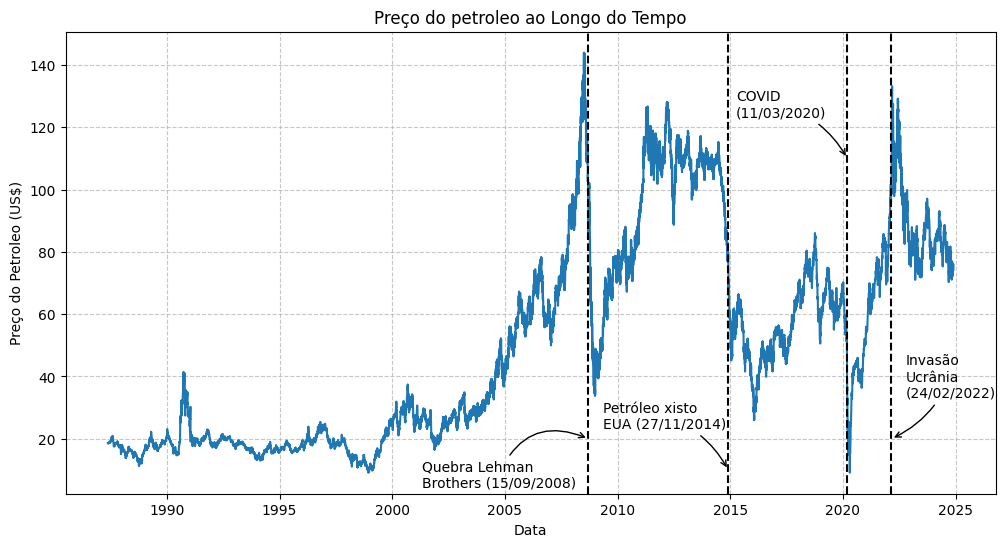

In [184]:
# Gráfico de linha do preço de petroleo

plt.figure(figsize=(12, 6))
plt.plot(df['Preco_Petroleo'], linestyle='-')
plt.title('Preço do petroleo ao Longo do Tempo')

plt.axvline(x=pd.to_datetime('2008-09-15'), color='k', ls='--') # Quebra Lehman Brothers https://pt.wikipedia.org/wiki/Crise_financeira_de_2007%E2%80%932008
plt.annotate('Quebra Lehman\nBrothers (15/09/2008)', xy=(pd.to_datetime('2008-09-15'), 20), xytext=(-120, -35),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.5'), color='k')

plt.axvline(x=pd.to_datetime('2014-11-27'), color='k', ls='--') # Petróleo xisto EUA https://g1.globo.com/economia/mercados/noticia/2014/11/opep-nao-ve-razao-para-queda-drastica-no-preco-do-petroleo.html
plt.annotate('Petróleo xisto\nEUA (27/11/2014)', xy=(pd.to_datetime('2014-11-27'), 10), xytext=(-90, 30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.2'), color='k')

plt.axvline(x=pd.to_datetime('2020-03-11'), color='k', ls='--') # Pandemia COVID https://pt.wikipedia.org/wiki/Pandemia_de_COVID-19
plt.annotate('COVID\n(11/03/2020)', xy=(pd.to_datetime('2020-03-11'), 110), xytext=(-80, 30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.2'), color='k')

plt.axvline(x=pd.to_datetime('2022-02-24'), color='k', ls='--') # Invasão da Ucrânia pela Rússia https://pt.wikipedia.org/wiki/Invas%C3%A3o_da_Ucr%C3%A2nia_pela_R%C3%BAssia_(2022%E2%80%93presente)
plt.annotate('Invasão\nUcrânia\n(24/02/2022)', xy=(pd.to_datetime('2022-02-24'), 20), xytext=(10, 30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.2'), color='k')

plt.xlabel('Data')
plt.ylabel('Preço do Petroleo (US$)')
plt.grid(alpha=0.7, linestyle='--')
plt.show()

In [185]:
# Estatísticas rolantes
rolmean = df['Preco_Petroleo'].rolling(window=12).mean()
rolstd = df['Preco_Petroleo'].rolling(window=12).std()

In [186]:
rolmean.head(15)

,Preco_Petroleo
Data,
1987-05-20,NaN
1987-05-21,NaN
1987-05-22,NaN
1987-05-25,NaN
1987-05-26,NaN
1987-05-27,NaN
1987-05-28,NaN
1987-05-29,NaN
1987-06-01,NaN


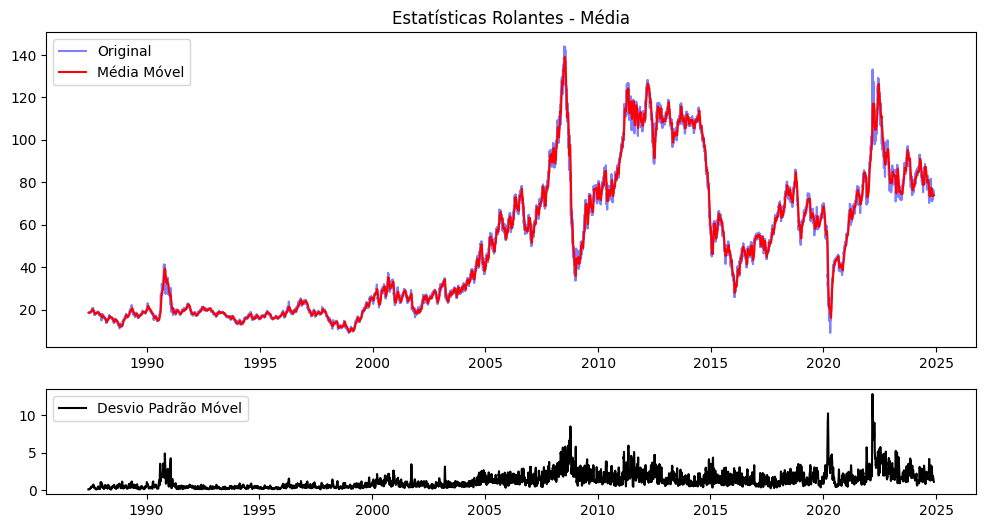

In [187]:
# Plot das estatísticas rolantes
fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0])
ax1.plot(df['Preco_Petroleo'], color='blue', label='Original', alpha=0.5)
ax1.plot(rolmean, color='red', label='Média Móvel')
ax1.legend(loc='best')
ax1.set_title('Estatísticas Rolantes - Média')

ax2 = fig.add_subplot(gs[1])
ax2.plot(rolstd, color='black', label='Desvio Padrão Móvel')
ax2.legend(loc='best')

plt.show()

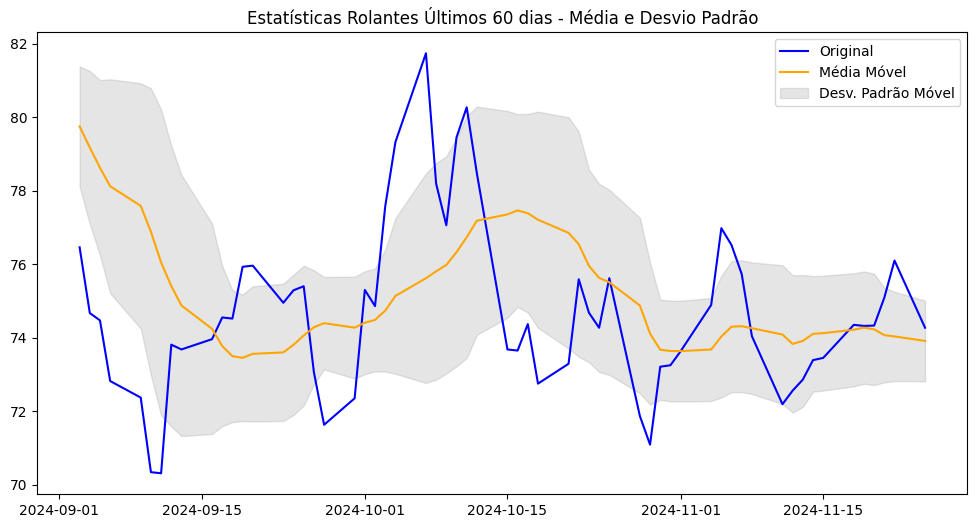

In [188]:
# Estatísticas Rolantes Últimos 60 dias

recent_days = 60

df_recent = df['Preco_Petroleo'][-recent_days:]
rolmean_recent = rolmean[-recent_days:]
rolstd_recent = rolstd[-recent_days:]

# Plot das estatísticas rolantes últimos 60 dias
plt.figure(figsize=(12, 6))
plt.plot(df_recent, color='blue', label='Original')
plt.plot(rolmean_recent, color='orange', label='Média Móvel')
plt.fill_between(df_recent.index, (rolmean_recent - rolstd_recent), (rolmean_recent + rolstd_recent), color='gray', alpha=0.2, label='Desv. Padrão Móvel')

plt.legend(loc='best')
plt.title('Estatísticas Rolantes Últimos 60 dias - Média e Desvio Padrão')
plt.show()

## Decomposição da série temporal

In [189]:
timeseries_decompose = seasonal_decompose(df['Preco_Petroleo'], model='additive', period=30)  # Exemplo de período sazonal de 30 dias

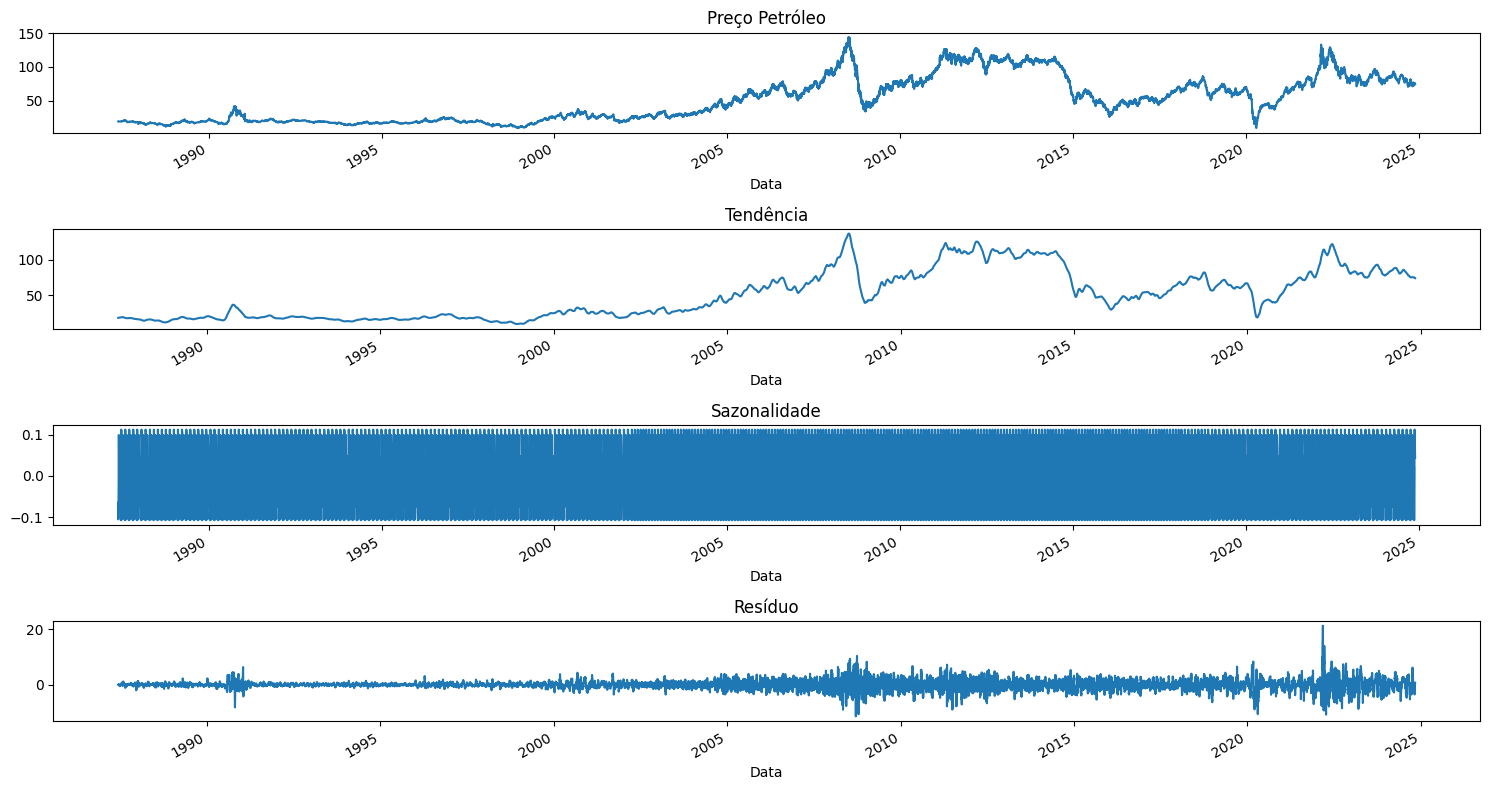

In [190]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

timeseries_decompose.observed.plot(ax = ax1, title='Preço Petróleo')

#tendencia
timeseries_decompose.trend.plot(ax = ax2, title='Tendência')

#sazonalidade
timeseries_decompose.seasonal.plot(ax = ax3, title='Sazonalidade')

#residuo dos dados
timeseries_decompose.resid.plot(ax = ax4, title='Resíduo')

plt.tight_layout()

Devido ao volume de dados, torna-se difícil analisar componentes como Tendência e Sazonalidade. Por isso, consideramos os últimos 2 anos (730 dias).

In [191]:
timeseries_decompose_recent = seasonal_decompose(df['Preco_Petroleo'][-730:], model='additive', period=30)  # Exemplo de período sazonal de 30 dias

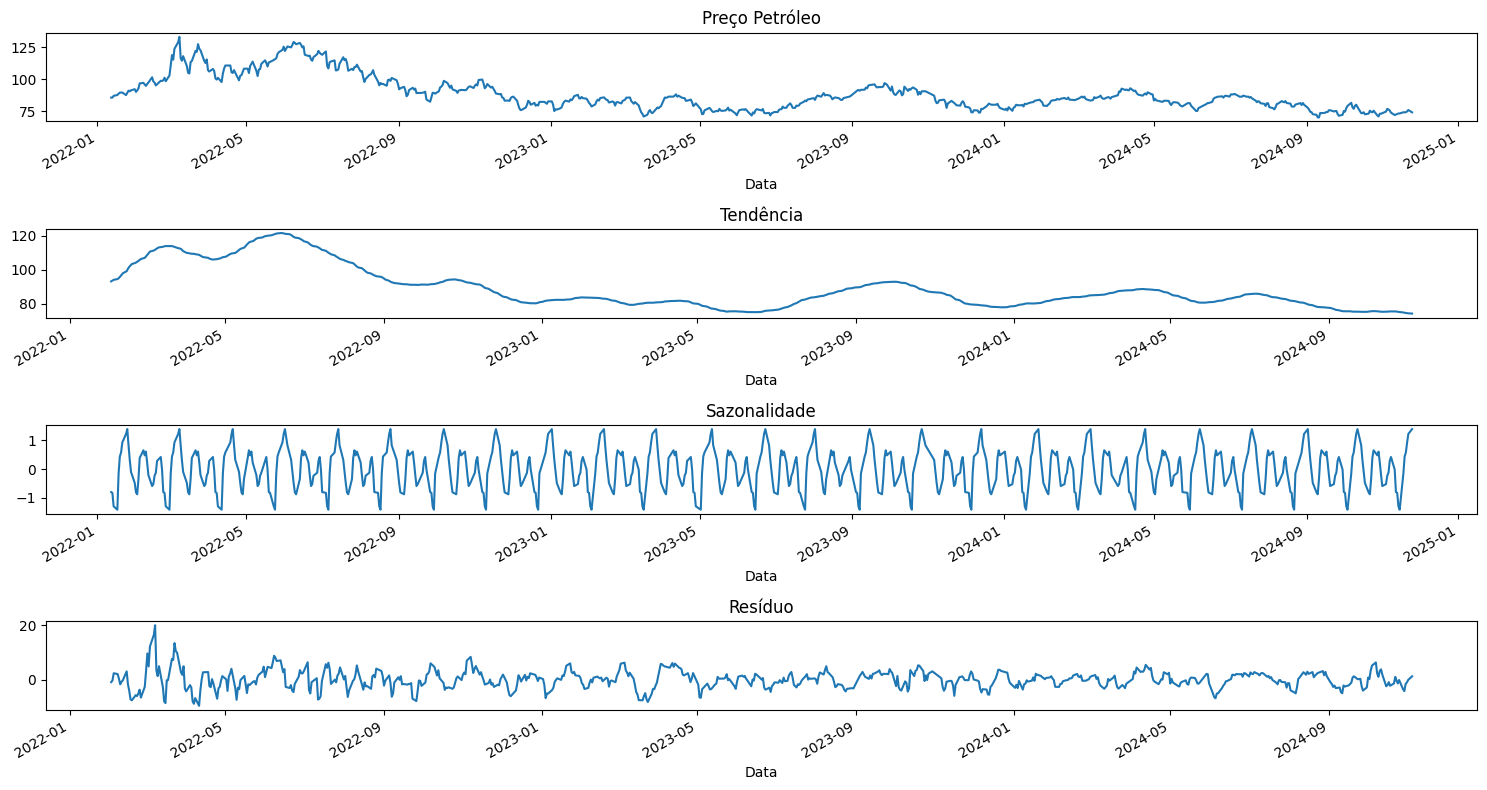

In [192]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

timeseries_decompose_recent.observed.plot(ax = ax1, title='Preço Petróleo')

#tendencia
timeseries_decompose_recent.trend.plot(ax = ax2, title='Tendência')

#sazonalidade
timeseries_decompose_recent.seasonal.plot(ax = ax3, title='Sazonalidade')

#residuo dos dados
timeseries_decompose_recent.resid.plot(ax = ax4, title='Resíduo')

plt.tight_layout()

# **2. Teste de Estacionaridade e Sazonalidade**

In [193]:
# Teste de Dickey-Fuller
print('Resultados do Teste de Dickey-Fuller:')
df_adftest = adfuller(df['Preco_Petroleo'], autolag='AIC')
dfoutput = pd.Series(df_adftest[0:4], index=['Estatística do Teste', 'Valor-p', 'Número de Lags Usados', 'Número de Observações Usadas'])
for key, value in df_adftest[4].items():
    dfoutput['Valor Crítico (%s)' % key] = value
print(dfoutput)

# Verificar o valor-p e imprimir o resultado do teste de estacionariedade
if df_adftest[1] > 0.05:
    print("H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)")
else:
    print("H1 - HIPOTESE ALTERNATIVA (REJEIÇÃO DA HIPOTESE NULA, OU SEJA, É ESTACIONÁRIA)")

Resultados do Teste de Dickey-Fuller:
Estatística do Teste               -2.131403
Valor-p                             0.232076
Número de Lags Usados              31.000000
Número de Observações Usadas    11275.000000
Valor Crítico (1%)                 -3.430930
Valor Crítico (5%)                 -2.861796
Valor Crítico (10%)                -2.566906
dtype: float64
H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)


## Análise do resultado

  * Estatística do Teste (ADF): -2.131403

A estatística do teste de Dickey-Fuller é significativamente maior que os valores críticos em todos os níveis de significância (1%, 5%, 10%). Isso indica que não temos evidências estatísticas suficientes para rejeitar a hipótese nula de que a série possui uma raiz unitária, ou seja, podemos considerar a série como não estacionária, ou seja, apresenta tendências claras, sazonalidades ou variações que dependam do tempo.

  * Valor-p: 0.23

O valor-p é não é pequeno (0.23), ou seja, 23% significativamente maior que qualquer nível de significância comum, algo em torno de 5% (0.05). Isso reforça ainda mais a conclusão de que a série não é estacionária.

**Conclusão**

Com base nos resultados do teste, podemos concluir que a série temporal do preço do petroleo não é estacionária. A estatística do teste de ADF é maior que os valores críticos correspondentes e o valor-p alto, comparado com o nivel de signficancia comum (5%), indicando que há raiz unitária na série e que ela não é estacionária.

Portanto, podemos proceder com confiança para modelagem e previsão usando métodos adequados para séries temporais como ARIMA por exemplo.

# **3. Predição**

In [194]:
df_modeling = df[['Preco_Petroleo']]
df_modeling

,Preco_Petroleo
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2024-11-19,74.32
2024-11-20,74.33
2024-11-21,75.09


In [195]:
df_modeling.shape

(11307, 1)

In [196]:
test_size = 30
train_size = df_modeling.shape[0] - test_size
train = df_modeling[:train_size]
test = df_modeling[train_size:]

In [197]:
train

,Preco_Petroleo
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2024-10-08,78.19
2024-10-09,77.06
2024-10-10,79.45


In [198]:
test

,Preco_Petroleo
Data,
2024-10-15,73.68
2024-10-16,73.65
2024-10-17,74.37
2024-10-18,72.75
2024-10-21,73.29
2024-10-22,75.59
2024-10-23,74.68
2024-10-24,74.27
2024-10-25,75.62


In [199]:
train.shape

(11277, 1)

# **Métricas de avaliação**

In [200]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(model, metrics):
    mae, mse, mape = metrics
    print(f'{model} Metrics:')
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

# **Treinando e avaliando modelos**

## **ARIMA**


In [201]:
# Preparando dados de treino para ARIMA
train_arima = train[['Preco_Petroleo']].copy()
train_arima = train_arima.asfreq('B')
train_arima.tail()

,Preco_Petroleo
Data,
2024-10-07,81.74
2024-10-08,78.19
2024-10-09,77.06
2024-10-10,79.45
2024-10-11,80.27


In [202]:
# Preparando dados de teste para ARIMA
test_arima = test[['Preco_Petroleo']].copy()
test_arima = test_arima.asfreq('B')
test_arima.head()

,Preco_Petroleo
Data,
2024-10-15,73.68
2024-10-16,73.65
2024-10-17,74.37
2024-10-18,72.75
2024-10-21,73.29


In [203]:
test_arima.dtypes

,0
Preco_Petroleo,float64


In [204]:
# Ajustando o modelo ARIMA
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

In [205]:
# Fazendo previsões
predict_arima = model_arima_fit.predict(start=len(train_arima), end=len(train_arima) + len(test_arima) - 1)

In [206]:
predict_arima

,predicted_mean
2024-10-14,79.575663
2024-10-15,79.781186
2024-10-16,79.968767
2024-10-17,79.917952
2024-10-18,79.904503
2024-10-21,79.930273
2024-10-22,79.933132
2024-10-23,79.928587
2024-10-24,79.930290
2024-10-25,79.931692


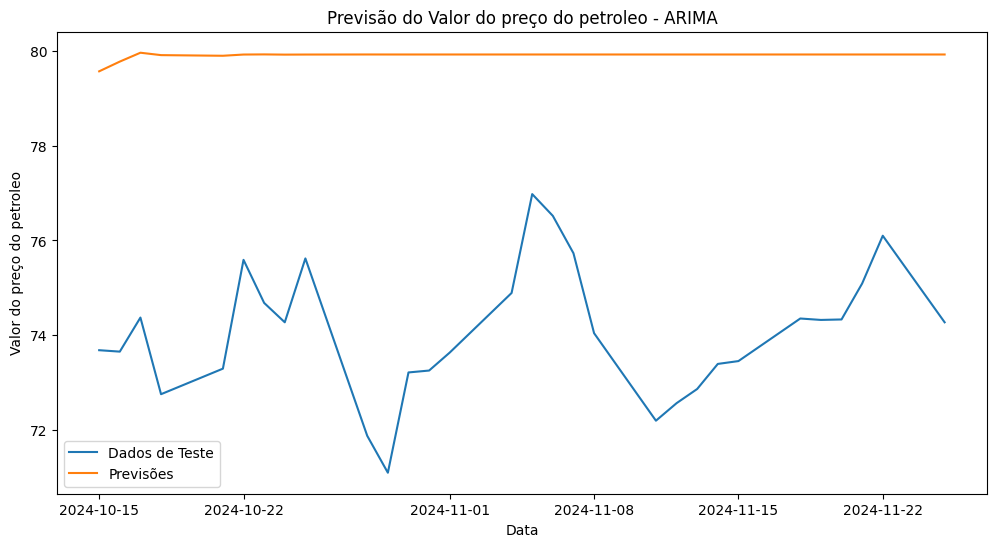

In [207]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
#plt.plot(train_arima[-test_size:], label='Dados de Treino')
plt.plot(test_arima.index, test_arima, label='Dados de Teste')
plt.plot(test_arima.index, predict_arima, label='Previsões')
plt.title('Previsão do Valor do preço do petroleo - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor do preço do petroleo')
plt.legend()
plt.show()

In [208]:
test_arima.tail()

,Preco_Petroleo
Data,
2024-11-19,74.32
2024-11-20,74.33
2024-11-21,75.09
2024-11-22,76.10
2024-11-25,74.27


In [209]:
# test_arima = test_arima.drop(pd.to_datetime('2024-10-14'))
# predict_arima = predict_arima.drop(pd.to_datetime('2024-10-14'))
#test_arima = test_arima.dropna(how='all')
#predict_arima = predict_arima.dropna(how='all')

In [210]:
metrics_arima = calculate_metrics(test_arima.values, predict_arima)
print_metrics('ARIMA', metrics_arima)

ARIMA Metrics:
MAE: 5.8469903893710535
MSE: 35.99738902408364
MAPE: 7.929802109437375


## **AUTOARIMA**

In [211]:
# Preparando dados de treino para AutoARIMA
train_autoarima = train.copy()
train_autoarima = train_autoarima.reset_index()
train_autoarima = train_autoarima.rename(columns={"Data": "ds", "Preco_Petroleo": "y"})
train_autoarima['unique_id'] = 'Preco Petroleo'
train_autoarima.tail()

,ds,y,unique_id
11272,2024-10-08,78.19,Preco Petroleo
11273,2024-10-09,77.06,Preco Petroleo
11274,2024-10-10,79.45,Preco Petroleo
11275,2024-10-11,80.27,Preco Petroleo
11276,2024-10-12,78.47,Preco Petroleo


In [212]:
# Preparando dados de teste para AutoARIMA
test_autoarima = test.copy()
test_autoarima = test_autoarima.reset_index()
test_autoarima = test_autoarima.rename(columns={"Data": "ds", "Preco_Petroleo": "y"})
test_autoarima['unique_id'] = 'Preco Petroleo'
test_autoarima.head()

,ds,y,unique_id
0,2024-10-15,73.68,Preco Petroleo
1,2024-10-16,73.65,Preco Petroleo
2,2024-10-17,74.37,Preco Petroleo
3,2024-10-18,72.75,Preco Petroleo
4,2024-10-21,73.29,Preco Petroleo


In [213]:
test_autoarima

,ds,y,unique_id
0,2024-10-15,73.68,Preco Petroleo
1,2024-10-16,73.65,Preco Petroleo
2,2024-10-17,74.37,Preco Petroleo
3,2024-10-18,72.75,Preco Petroleo
4,2024-10-21,73.29,Preco Petroleo
5,2024-10-22,75.59,Preco Petroleo
6,2024-10-23,74.68,Preco Petroleo
7,2024-10-24,74.27,Preco Petroleo
8,2024-10-25,75.62,Preco Petroleo
9,2024-10-28,71.87,Preco Petroleo


In [214]:
X_df_autorima = test_autoarima[['ds', 'y', 'unique_id']]
X_df_autorima.head()

,ds,y,unique_id
0,2024-10-15,73.68,Preco Petroleo
1,2024-10-16,73.65,Preco Petroleo
2,2024-10-17,74.37,Preco Petroleo
3,2024-10-18,72.75,Preco Petroleo
4,2024-10-21,73.29,Preco Petroleo


In [215]:
train_autoarima.head()

,ds,y,unique_id
0,1987-05-20,18.63,Preco Petroleo
1,1987-05-21,18.45,Preco Petroleo
2,1987-05-22,18.55,Preco Petroleo
3,1987-05-25,18.60,Preco Petroleo
4,1987-05-26,18.63,Preco Petroleo


In [216]:
X_df_autorima.head()

,ds,y,unique_id
0,2024-10-15,73.68,Preco Petroleo
1,2024-10-16,73.65,Preco Petroleo
2,2024-10-17,74.37,Preco Petroleo
3,2024-10-18,72.75,Preco Petroleo
4,2024-10-21,73.29,Preco Petroleo


In [217]:
X_df_autorima = test_autoarima[['ds', 'unique_id']]
#X_df_autorima.set_index('ds', inplace=True)

model_autoarima = StatsForecast(models=[AutoARIMA(season_length=1)], freq='B',n_jobs=-1)
model_autoarima.fit(train_autoarima)
predict_autoarima = model_autoarima.predict(h=test_size, level = [90], X_df = X_df_autorima)
predict_autoarima.tail()

/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:1150: UserWarning:

xreg not required by this model, ignoring the provided regressors



,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
25,Preco Petroleo,2024-11-18,79.140375,69.442791,88.837958
26,Preco Petroleo,2024-11-19,79.147003,69.243706,89.050300
27,Preco Petroleo,2024-11-20,79.153320,69.047279,89.259360
28,Preco Petroleo,2024-11-21,79.159351,68.853411,89.465290
29,Preco Petroleo,2024-11-22,79.165109,68.662003,89.668215


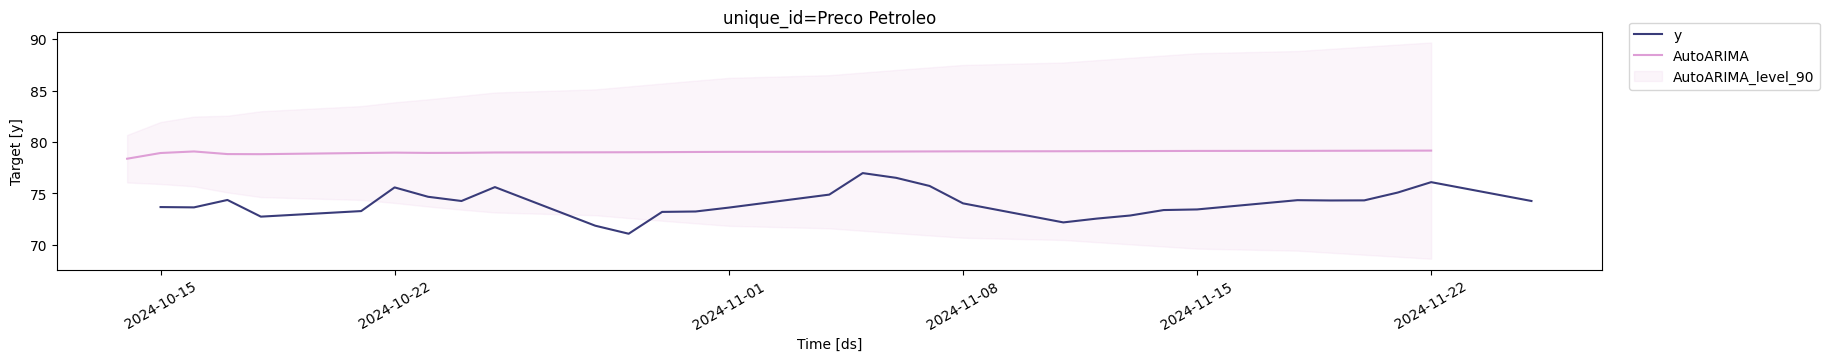

In [218]:
model_autoarima.plot(test_autoarima, predict_autoarima, level = [90], unique_ids = ['Preco Petroleo'], engine = 'matplotlib')

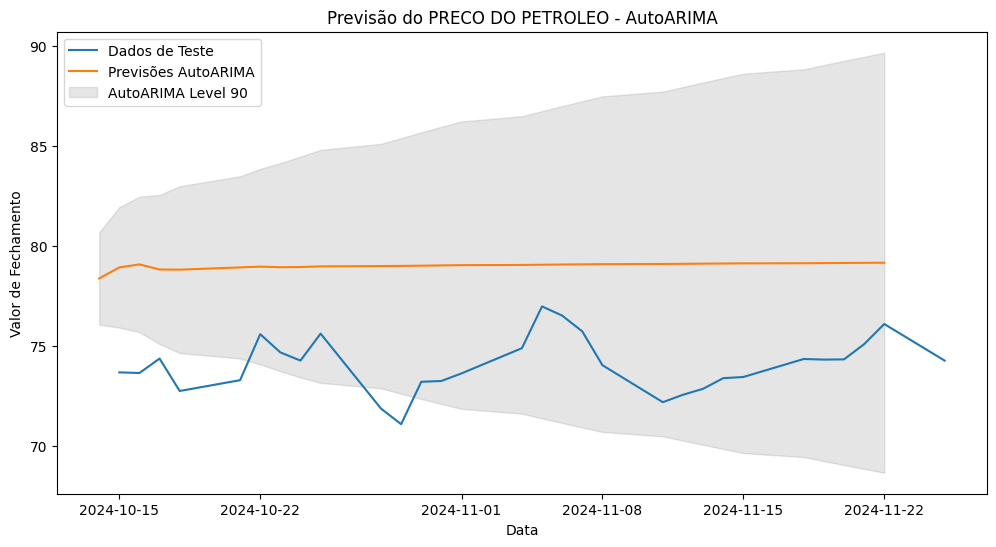

In [219]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_autoarima['ds'], test_autoarima['y'], label='Dados de Teste')
plt.plot(predict_autoarima['ds'], predict_autoarima['AutoARIMA'], label='Previsões AutoARIMA')
plt.fill_between(predict_autoarima['ds'], predict_autoarima['AutoARIMA-lo-90'], predict_autoarima['AutoARIMA-hi-90'], color='gray', alpha=0.2, label='AutoARIMA Level 90')

plt.title('Previsão do PRECO DO PETROLEO - AutoARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='upper left')
plt.show()

In [220]:
metrics_autoarima = calculate_metrics(test_autoarima['y'].values, predict_autoarima['AutoARIMA'].values)
print_metrics('AutoARIMA', metrics_autoarima)

AutoARIMA Metrics:
MAE: 4.953614522127901
MSE: 26.320126933988117
MAPE: 6.72281236117412


## **PROPHET**

In [221]:
# train['Preco_2'] = train['Preco_Petroleo']  # Criar valor_2 como o dobro de valor
#train.head()

In [222]:
# Preparando dados de treino para o Prophet
train_prophet = train.copy()
train_prophet = train_prophet.reset_index()
train_prophet = train_prophet.rename(columns={'Data': 'ds', 'Preco_Petroleo': 'y'})
train_prophet.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [223]:
# test['Preco_2'] = test['Preco_Petroleo']  # Criar valor_2 como o dobro de valor
test.head()

,Preco_Petroleo
Data,
2024-10-15,73.68
2024-10-16,73.65
2024-10-17,74.37
2024-10-18,72.75
2024-10-21,73.29


In [224]:
# Preparando dados de teste para o Prophet
test_prophet = test.copy()
test_prophet = test_prophet.reset_index()
test_prophet = test_prophet.rename(columns={'Data': 'ds', 'Preco_Petroleo': 'y'})
test_prophet

,ds,y
0,2024-10-15,73.68
1,2024-10-16,73.65
2,2024-10-17,74.37
3,2024-10-18,72.75
4,2024-10-21,73.29
5,2024-10-22,75.59
6,2024-10-23,74.68
7,2024-10-24,74.27
8,2024-10-25,75.62
9,2024-10-28,71.87


In [225]:
model_prophet = Prophet(weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False)

#model_prophet.add_country_holidays(country_name='BR')
# model_prophet.add_regressor('Preco_2')

model_prophet.fit(train_prophet)

future_prophet= model_prophet.make_future_dataframe(periods=test_size, freq='B') # freq='B' (dias úteis - business days)
# future_prophet['Preco_2'] = pd.concat([train_prophet['Preco_2'], test_prophet['Preco_2'], test_prophet['Preco_2']], ignore_index=True)

predict_prophet = model_prophet.predict(future_prophet)
predict_prophet.sort_values(by='ds')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcs2khc7u/v5_vdwjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcs2khc7u/oi7l581n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40940', 'data', 'file=/tmp/tmpcs2khc7u/v5_vdwjr.json', 'init=/tmp/tmpcs2khc7u/oi7l581n.json', 'output', 'file=/tmp/tmpcs2khc7u/prophet_modelti_kvfxk/prophet_model-20241203171921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,16.406557,3.278250,33.167966,16.406557,16.406557,1.282059,1.282059,1.282059,1.282059,1.282059,1.282059,0.0,0.0,0.0,17.688617
1,1987-05-21,16.409542,4.180972,31.929246,16.409542,16.409542,1.293462,1.293462,1.293462,1.293462,1.293462,1.293462,0.0,0.0,0.0,17.703004
2,1987-05-22,16.412527,4.303116,31.351371,16.412527,16.412527,1.301914,1.301914,1.301914,1.301914,1.301914,1.301914,0.0,0.0,0.0,17.714441
3,1987-05-25,16.421481,3.484832,30.323477,16.421481,16.421481,1.310461,1.310461,1.310461,1.310461,1.310461,1.310461,0.0,0.0,0.0,17.731942
4,1987-05-26,16.424466,3.338812,32.187149,16.424466,16.424466,1.308360,1.308360,1.308360,1.308360,1.308360,1.308360,0.0,0.0,0.0,17.732826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,2024-11-18,90.328369,74.826777,102.071435,90.328369,90.328369,-1.426403,-1.426403,-1.426403,-1.426403,-1.426403,-1.426403,0.0,0.0,0.0,88.901966
11303,2024-11-19,90.342052,74.523349,101.089377,90.342052,90.342052,-1.486608,-1.486608,-1.486608,-1.486608,-1.486608,-1.486608,0.0,0.0,0.0,88.855444
11304,2024-11-20,90.355735,75.009271,102.672268,90.355735,90.355735,-1.546795,-1.546795,-1.546795,-1.546795,-1.546795,-1.546795,0.0,0.0,0.0,88.808940
11305,2024-11-21,90.369419,75.725833,102.291697,90.369419,90.369419,-1.607034,-1.607034,-1.607034,-1.607034,-1.607034,-1.607034,0.0,0.0,0.0,88.762384


In [226]:
model_prophet.train_holiday_names

In [227]:
prophet_plot(model_prophet, predict_prophet)

In [228]:
predict_prophet_test = predict_prophet.tail(test_size)[['ds', 'yhat']].reset_index(drop=True)
predict_prophet_test.tail()

,ds,yhat
25,2024-11-18,88.901966
26,2024-11-19,88.855444
27,2024-11-20,88.808940
28,2024-11-21,88.762384
29,2024-11-22,88.715734


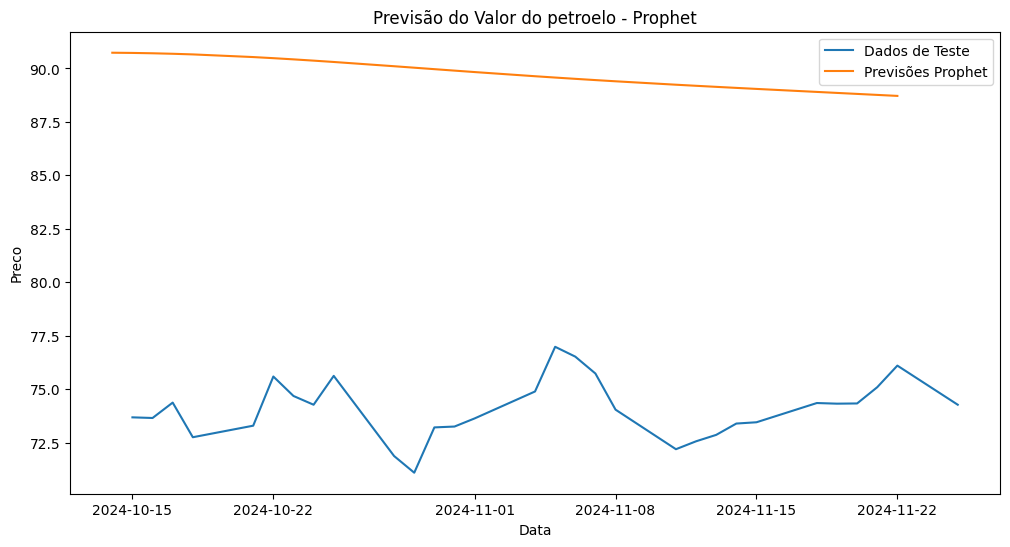

In [229]:
# Visualizando as previsões do modelo Prophet
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Dados de Teste')
plt.plot(predict_prophet_test['ds'], predict_prophet_test['yhat'], label='Previsões Prophet')

plt.title('Previsão do Valor do petroelo - Prophet')
plt.xlabel('Data')
plt.ylabel('Preco')
plt.legend(loc='best')
plt.show()

In [230]:
metrics_prophet = calculate_metrics(test_prophet['y'].values, predict_prophet_test['yhat'].values)
print_metrics('Prophet', metrics_prophet)

Prophet Metrics:
MAE: 15.691889595530263
MSE: 248.81176408647565
MAPE: 21.22888204290108


### **Testando Overfit do Prophet**

In [231]:
# Filtrar previsões para o período de treinamento e teste
predict_prophet_train = predict_prophet[predict_prophet['ds'] < '2024-06-11']
predict_prophet_train

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,16.406557,3.278250,33.167966,16.406557,16.406557,1.282059,1.282059,1.282059,1.282059,1.282059,1.282059,0.0,0.0,0.0,17.688617
1,1987-05-21,16.409542,4.180972,31.929246,16.409542,16.409542,1.293462,1.293462,1.293462,1.293462,1.293462,1.293462,0.0,0.0,0.0,17.703004
2,1987-05-22,16.412527,4.303116,31.351371,16.412527,16.412527,1.301914,1.301914,1.301914,1.301914,1.301914,1.301914,0.0,0.0,0.0,17.714441
3,1987-05-25,16.421481,3.484832,30.323477,16.421481,16.421481,1.310461,1.310461,1.310461,1.310461,1.310461,1.310461,0.0,0.0,0.0,17.731942
4,1987-05-26,16.424466,3.338812,32.187149,16.424466,16.424466,1.308360,1.308360,1.308360,1.308360,1.308360,1.308360,0.0,0.0,0.0,17.732826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11183,2024-06-04,88.043254,75.879126,102.805805,88.043254,88.043254,1.244248,1.244248,1.244248,1.244248,1.244248,1.244248,0.0,0.0,0.0,89.287502
11184,2024-06-05,88.056937,75.966486,102.314780,88.056937,88.056937,1.241533,1.241533,1.241533,1.241533,1.241533,1.241533,0.0,0.0,0.0,89.298470
11185,2024-06-06,88.070621,75.683365,103.303292,88.070621,88.070621,1.240803,1.240803,1.240803,1.240803,1.240803,1.240803,0.0,0.0,0.0,89.311424
11186,2024-06-07,88.084304,76.259675,102.503024,88.084304,88.084304,1.242240,1.242240,1.242240,1.242240,1.242240,1.242240,0.0,0.0,0.0,89.326544


In [232]:
# Supondo que você tenha previsões para treinamento e teste
mape_train = np.abs((train_prophet['y'] - predict_prophet_train['yhat']) / train_prophet['y']).mean() * 100
mape_test = np.abs((test_prophet['y'] - predict_prophet_test['yhat']) / test_prophet['y']).mean() * 100

print(f"MAPE nos Dados de Treinamento: {mape_train:.2f}%")
print(f"MAPE nos Dados de Teste: {mape_test:.2f}%")

MAPE nos Dados de Treinamento: 15.17%
MAPE nos Dados de Teste: 21.23%


#### Conclusão

O fato de o MAPE nos dados de teste ser menor do que nos dados de treinamento não é comum e **não é um sinal típico de overfitting**.


Overfitting geralmente é indicado por um MAPE muito baixo em dados de treinamento e um MAPE significativamente maior em dados de teste. Nesse caso, o MAPE em dados de teste é menor, o que pode indicar que o modelo está generalizando bem e, possivelmente, foi ajustado de forma robusta.

## **XGBoost**

In [233]:
# Preparando dados de treino para o XGBoost
train_xgb = train.copy()
train_xgb = train_xgb.reset_index()
train_xgb['ano'] = train_xgb['Data'].dt.year
train_xgb['mes'] = train_xgb['Data'].dt.month
train_xgb['dia'] = train_xgb['Data'].dt.day
train_xgb['diadasemana'] = train_xgb['Data'].dt.dayofweek
train_xgb.tail()

,Data,Preco_Petroleo,ano,mes,dia,diadasemana
11272,2024-10-08,78.19,2024,10,8,1
11273,2024-10-09,77.06,2024,10,9,2
11274,2024-10-10,79.45,2024,10,10,3
11275,2024-10-11,80.27,2024,10,11,4
11276,2024-10-12,78.47,2024,10,12,5


In [234]:
# Preparando dados de teste para o XGBoost
test_xgb = test.copy()
test_xgb = test_xgb.reset_index()
test_xgb['ano'] = test_xgb['Data'].dt.year
test_xgb['mes'] = test_xgb['Data'].dt.month
test_xgb['dia'] = test_xgb['Data'].dt.day
test_xgb['diadasemana'] = test_xgb['Data'].dt.dayofweek
test_xgb

,Data,Preco_Petroleo,ano,mes,dia,diadasemana
0,2024-10-15,73.68,2024,10,15,1
1,2024-10-16,73.65,2024,10,16,2
2,2024-10-17,74.37,2024,10,17,3
3,2024-10-18,72.75,2024,10,18,4
4,2024-10-21,73.29,2024,10,21,0
5,2024-10-22,75.59,2024,10,22,1
6,2024-10-23,74.68,2024,10,23,2
7,2024-10-24,74.27,2024,10,24,3
8,2024-10-25,75.62,2024,10,25,4
9,2024-10-28,71.87,2024,10,28,0


In [235]:
FEATURES = ['ano', 'mes', 'dia', 'diadasemana']
TARGET = 'Preco_Petroleo'

X_train_xgb, y_train_xgb = train_xgb[FEATURES], train_xgb[TARGET]
X_test_xgb, y_test_xgb = test_xgb[FEATURES], test_xgb[TARGET]

reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(X_train_xgb, y_train_xgb)

# Avaliação XGBoost
predict_xgb = reg.predict(X_test_xgb)
predict_xgb

array([78.81374 , 78.02949 , 78.34701 , 79.49008 , 79.089195, 77.27365 ,
       77.459465, 77.46579 , 77.45211 , 77.17177 , 76.72128 , 76.93531 ,
       76.19378 , 76.847404, 78.342865, 77.57917 , 73.96959 , 73.664764,
       74.12831 , 75.87718 , 75.2999  , 75.02672 , 75.10123 , 75.22234 ,
       76.9759  , 75.5839  , 75.23868 , 74.70554 , 73.90624 , 75.097466],
      dtype=float32)

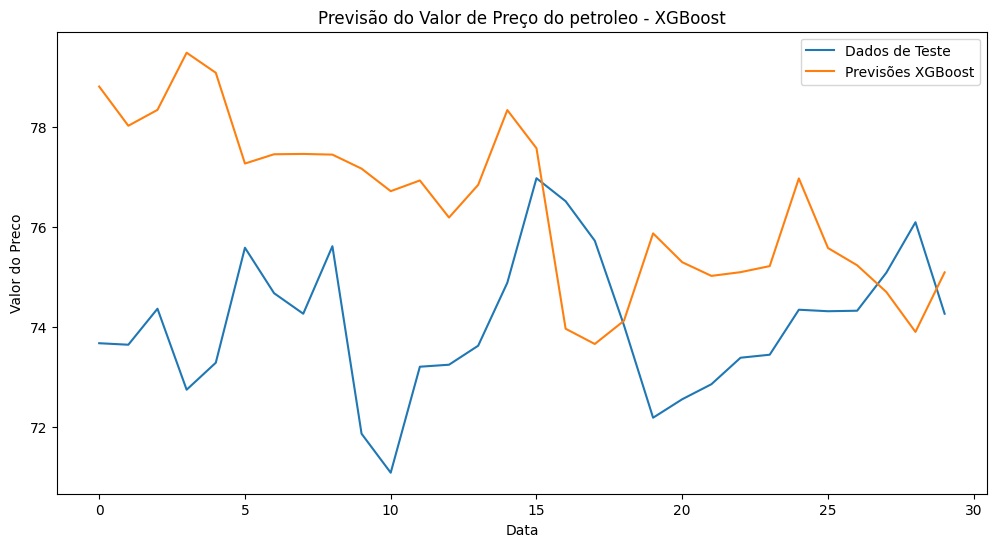

In [236]:
# Visualizando as previsões do modelo XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_test_xgb.index, y_test_xgb, label='Dados de Teste')
plt.plot(X_test_xgb.index, predict_xgb, label='Previsões XGBoost')

plt.title('Previsão do Valor de Preço do petroleo - XGBoost')
plt.xlabel('Data')
plt.ylabel('Valor do Preco')
plt.legend(loc='best')
plt.show()

In [237]:
metrics_xgb = calculate_metrics(y_test_xgb, predict_xgb)
print_metrics('XGBoost', metrics_xgb)

XGBoost Metrics:
MAE: 2.8459197794596345
MSE: 10.904850112275188
MAPE: 3.8674445797780033


## **SARIMAX**

In [238]:
# Preparando dados de treino para SARIMAX
train_sarimax = train[['Preco_Petroleo']].copy()
train_sarimax = train_sarimax.asfreq('B')
train_sarimax.tail()

,Preco_Petroleo
Data,
2024-10-07,81.74
2024-10-08,78.19
2024-10-09,77.06
2024-10-10,79.45
2024-10-11,80.27


In [239]:
# Preparando dados de teste para SARIMAX
test_sarimax = test[['Preco_Petroleo']].copy()
test_sarimax = test_sarimax.asfreq('B')
test_sarimax.tail()

,Preco_Petroleo
Data,
2024-11-19,74.32
2024-11-20,74.33
2024-11-21,75.09
2024-11-22,76.10
2024-11-25,74.27


In [240]:
model_sarimax = SARIMAX(train_sarimax, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarimax = model_sarimax.fit()

predict_sarimax = fit_sarimax.get_forecast(steps=len(test_sarimax)).predicted_mean

In [241]:
predict_sarimax

,predicted_mean
2024-10-14,79.942680
2024-10-15,79.842139
2024-10-16,79.959456
2024-10-17,80.015247
2024-10-18,79.943827
2024-10-21,80.003375
2024-10-22,80.054926
2024-10-23,80.125254
2024-10-24,80.036148
2024-10-25,79.984839


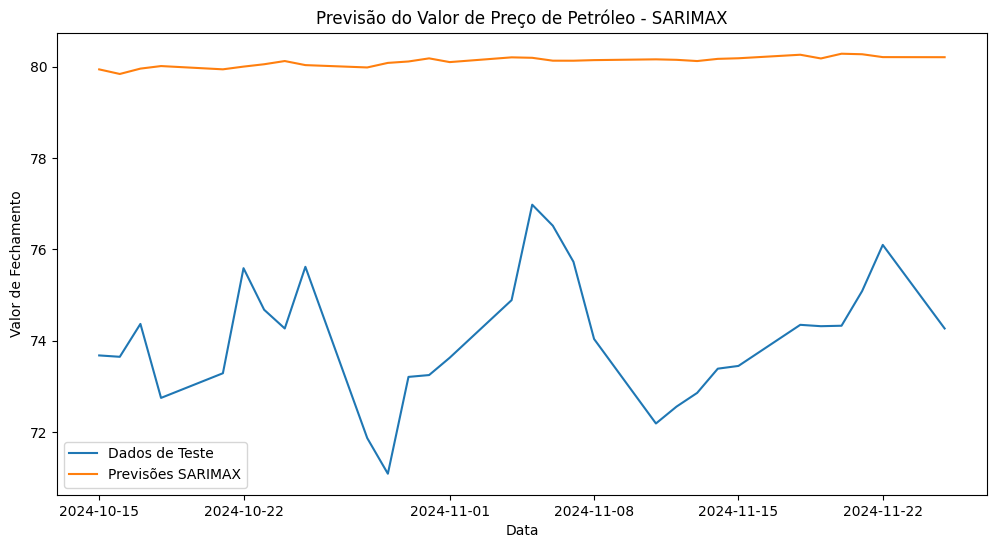

In [242]:
# Visualizando as previsões do modelo SARIMAX
plt.figure(figsize=(12, 6))
plt.plot(test_sarimax.index, test_sarimax['Preco_Petroleo'], label='Dados de Teste')
plt.plot(test_sarimax.index, predict_sarimax, label='Previsões SARIMAX')

plt.title('Previsão do Valor de Preço de Petróleo - SARIMAX')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [243]:
metrics_sarimax = calculate_metrics(test_sarimax['Preco_Petroleo'].values, predict_sarimax)
print_metrics('SARIMAX', metrics_sarimax)

SARIMAX Metrics:
MAE: 6.047026213605026
MSE: 38.33165590866487
MAPE: 8.199489033117754


## **Comparação dos Modelos**

In [245]:
df_metrics = pd.DataFrame(
    [metrics_arima, metrics_autoarima, metrics_prophet, metrics_xgb, metrics_sarimax],
    columns=['MAE', 'MSE', 'MAPE'],
    index=['ARIMA', 'AutoARIMA', 'Prophet', 'XGBoost', 'SARIMAX'],
).sort_values(by='MAPE', ascending=True)
df_metrics

,MAE,MSE,MAPE
XGBoost,2.845920,10.904850,3.867445
AutoARIMA,4.953615,26.320127,6.722812
ARIMA,5.846990,35.997389,7.929802
SARIMAX,6.047026,38.331656,8.199489
Prophet,15.691890,248.811764,21.228882


# **Predição do Preço do Petróleo Brent para o próximo dia**

O modelo com melhor resultado considerando as métricas de erro foi o **XGBoost**.

Por isso, vamos considerar todos os dados disponíveis para retreinar o modelo, predizendo o próximo dia do dataset como o modelo atualizado do XGBoost.

In [248]:
ultimo_dia = df_modeling.index[-1]
ultimo_dia

Timestamp('2024-11-25 00:00:00')

In [278]:
df_modeling['Preco_Petroleo'].values[-1]

74.27

In [250]:
proximo_dia = ultimo_dia + relativedelta(days=1)
proximo_dia

Timestamp('2024-11-26 00:00:00')

In [254]:
train_xgb_next = df_modeling.copy()
train_xgb_next = train_xgb_next.reset_index()
train_xgb_next['ano'] = train_xgb_next['Data'].dt.year
train_xgb_next['mes'] = train_xgb_next['Data'].dt.month
train_xgb_next['dia'] = train_xgb_next['Data'].dt.day
train_xgb_next['diadasemana'] = train_xgb_next['Data'].dt.dayofweek
train_xgb_next.tail()

,Data,Preco_Petroleo,ano,mes,dia,diadasemana
11302,2024-11-19,74.32,2024,11,19,1
11303,2024-11-20,74.33,2024,11,20,2
11304,2024-11-21,75.09,2024,11,21,3
11305,2024-11-22,76.10,2024,11,22,4
11306,2024-11-25,74.27,2024,11,25,0


In [ ]:
X_proximo_dia = pd.DataFrame({
    'ano': [proximo_dia.year],
    'mes': [proximo_dia.month],
    'dia': [proximo_dia.day],
    'diadasemana': [proximo_dia.dayofweek]
})
X_proximo_dia

In [255]:
FEATURES = ['ano', 'mes', 'dia', 'diadasemana']
TARGET = 'Preco_Petroleo'
X_train_xgb, y_train_xgb = train_xgb[FEATURES], train_xgb[TARGET]

In [276]:
reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(X_train_xgb, y_train_xgb)
predict_xgb = reg.predict(X_proximo_dia)
preco_previsto = predict_xgb[0]
preco_previsto

72.08811